# A Taster of the Pytorch Framework

## Benchmark Case

### Imports

In [1]:
import numpy as np
import torch

In [2]:
import matplotlib.pyplot as plt

### Data Setup

In [3]:
num_samples = 100000

In [4]:
y = np.random.binomial(1,0.5,num_samples)
x = np.c_[np.random.normal(y,0.8),np.random.normal(-y,0.8)]

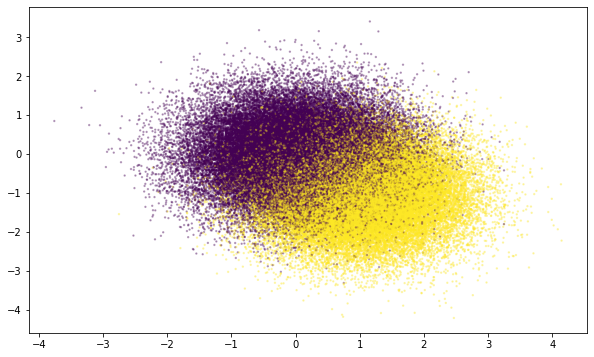

In [471]:
fig = plt.figure(figsize=(10,6))
plt.scatter(x[:,0],x[:,1], c=y, s=2, alpha=0.3)

### Dataset & Dataloader Setup

0. Import torch and define the device we're going to use

In [ ]:
import torch
import torch.utils.data as data
device = "cuda" if torch.cuda.is_available() else "cpu"

1. Convert everything to torch tensors - trivial from Numpy! (One gotcha - Pytorch likes things in float=float32, not double=float64)

In [473]:
y_tensor = torch.from_numpy(y).float()
x_tensor = torch.from_numpy(x).float()

2. Pick a train, val, test split

In [474]:
train, val, test = int(num_samples*0.8), int(num_samples*0.1), int(num_samples*0.1)

3. Make a `Torch Dataset` (specifically a `TensorDataset`, which simplifies much of the boilerplate of `getting` items), and split it

In [475]:
full_dataset = data.TensorDataset(x_tensor, y_tensor)

In [476]:
train_dataset, val_dataset, test_dataset = data.random_split(full_dataset, [train, val, test])

In [477]:
train_dataloader, val_dataloader, test_dataloader = (
                                                    data.DataLoader(train_dataset, batch_size=100000), 
                                                    data.DataLoader(val_dataset, batch_size=10000), 
                                                    data.DataLoader(test_dataset)
                                                    )

### Model Definition

In [483]:
import torch.nn as nn
import torch.nn.functional as F

We can define a model as either a bare sequential module:

In [491]:
model = nn.Sequential( 
            nn.Linear(2, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
            )

or as a new class, where the `forward` method is what is called when we apply the model as `model(batch)`:

In [510]:
class DenseNet(nn.Module):

    def __init__(self):
        super().__init__()
        
        self.classifier = nn.Sequential(
            nn.Linear(2, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )

    def forward(self, x):
        # in lightning, forward defines the prediction/inference actions
        output = self.classifier(x)
        return output

In [506]:
model = DenseNet()

### Training & Validation

In [507]:
# HParams
lr = 0.1
num_epochs = 20

In [508]:
optimizer = torch.optim.AdamW(model.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 50, 0.3)

In [509]:
%%time
# Epoch loop
for epoch in range(num_epochs):
    
    model.train()
    
    # Batch loop
    train_loss = 0
    for batch in train_dataloader:
        
        batch_x, batch_y = batch[0], batch[1]
        
        output = model(batch_x).squeeze()
        
#         output = torch.sigmoid(output)
#         loss = F.mse_loss(output, batch_y)
        
        loss = F.binary_cross_entropy_with_logits(output, batch_y.squeeze())
        
        train_loss += loss.item()
        
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()
        
    model.eval()
    
    val_loss = 0
    total_correct = 0
    for batch in val_dataloader:
        
        batch_x, batch_y = batch[0], batch[1]
        
        with torch.no_grad():
            output = model(batch_x).squeeze()
        
        total_correct += ((torch.sigmoid(output) > 0.5) == batch_y).sum().item()
        print(total_correct)
        val_loss += F.binary_cross_entropy_with_logits(output, batch_y.squeeze())
#         val_loss += F.mse_loss(output, batch_y)
        
    scheduler.step()
    accuracy = total_correct / len(val_dataset) * 100
    print(f"Epoch {epoch} trained with train loss {train_loss}, val loss {val_loss}, accuracy {accuracy}%")    

5018
Epoch 0 trained with train loss 0.7035202383995056, val loss 0.6926969885826111, accuracy 50.18%
5019
Epoch 1 trained with train loss 0.6940795183181763, val loss 0.6447372436523438, accuracy 50.19%
7585
Epoch 2 trained with train loss 0.6466198563575745, val loss 0.5788593888282776, accuracy 75.85%
7806
Epoch 3 trained with train loss 0.5814706087112427, val loss 0.49696841835975647, accuracy 78.06%
7999
Epoch 4 trained with train loss 0.5019424557685852, val loss 0.439668744802475, accuracy 79.99000000000001%
7938
Epoch 5 trained with train loss 0.44763925671577454, val loss 0.4541981816291809, accuracy 79.38%
8173
Epoch 6 trained with train loss 0.46308839321136475, val loss 0.45286718010902405, accuracy 81.73%
8156
Epoch 7 trained with train loss 0.46586504578590393, val loss 0.44796493649482727, accuracy 81.56%
8076
Epoch 8 trained with train loss 0.460477739572525, val loss 0.42850616574287415, accuracy 80.76%
7997
Epoch 9 trained with train loss 0.43812796473503113, val los

### Model on GPU

Just reinstantiate the model and optimiser, then send it to `device`

In [487]:
model = model.to(device)

In [488]:
%%time
# Epoch loop
for epoch in range(num_epochs):
    
    model.train()
    
    # Batch loop
    train_loss = 0
    for batch in train_dataloader:
        
        batch_x, batch_y = batch[0].to(device), batch[1].to(device)
        
        output = model(batch_x).squeeze()
        
#         output = torch.sigmoid(output)
#         loss = F.mse_loss(output, batch_y)
        
        loss = F.binary_cross_entropy_with_logits(output, batch_y.squeeze())
        
        train_loss += loss.item()
        
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()
        
    model.eval()
    
    val_loss = 0
    total_correct = 0
    for batch in val_dataloader:
        
        batch_x, batch_y = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(batch_x).squeeze()
        
        total_correct += ((torch.sigmoid(output) > 0.5) == batch_y).sum().item()
        print(total_correct)
        val_loss += F.binary_cross_entropy_with_logits(output, batch_y.squeeze())
#         val_loss += F.mse_loss(output, batch_y)
        
    scheduler.step()
    accuracy = total_correct / len(val_dataset) * 100
    print(f"Epoch {epoch} trained with train loss {train_loss}, val loss {val_loss}, accuracy {accuracy}%")    

7093
Epoch 0 trained with train loss 0.7019893527030945, val loss 0.6544415354728699, accuracy 70.93%
8014
Epoch 1 trained with train loss 0.654761791229248, val loss 0.5644843578338623, accuracy 80.14%
8091
Epoch 2 trained with train loss 0.5655666589736938, val loss 0.45007243752479553, accuracy 80.91000000000001%
8136
Epoch 3 trained with train loss 0.4549972414970398, val loss 0.43923047184944153, accuracy 81.36%
8148
Epoch 4 trained with train loss 0.4529171288013458, val loss 0.46818777918815613, accuracy 81.47999999999999%
8138
Epoch 5 trained with train loss 0.48407313227653503, val loss 0.440435528755188, accuracy 81.38%
8150
Epoch 6 trained with train loss 0.45380789041519165, val loss 0.4134869873523712, accuracy 81.5%
8155
Epoch 7 trained with train loss 0.4233400821685791, val loss 0.4151534140110016, accuracy 81.55%
8157
Epoch 8 trained with train loss 0.4211347997188568, val loss 0.4243483245372772, accuracy 81.57%
8151
Epoch 9 trained with train loss 0.42994412779808044

### Testing

In [540]:
test_output = torch.sigmoid(model(test_dataset[:][0]))

In [541]:
test_pred = test_output > 0.5

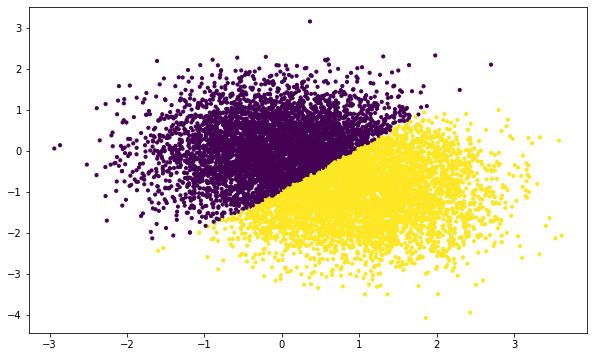

In [542]:
plt.figure(figsize=(10,6))
test_x = test_dataset[:][0].numpy()[:, 0]
test_y = test_dataset[:][0].numpy()[:, 1]
plt.scatter(test_x, test_y, c = test_pred, s=10)

## Bells & Whistles

Pytorch Lightning doesn't need another advocate, but I love it. Compare the above mess with:

In [512]:
import pytorch_lightning as pl

In [552]:
class DenseNet(pl.LightningModule):

    def __init__(self):
        super().__init__()
        
        self.classifier = nn.Sequential(
            nn.Linear(2, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )

    def forward(self, x):
        output = self.classifier(x)
        return output

    def training_step(self, batch, batch_idx):
        x, y = batch
        
        output = self(x).squeeze()
        
        loss = F.binary_cross_entropy_with_logits(output, y)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        
        output = self(x).squeeze()
        
        loss = F.binary_cross_entropy_with_logits(output, y)
        
        acc = ((torch.sigmoid(output) > 0.5) == y).sum().item() / len(y)
        self.log_dict({'val_loss': loss, 'acc': acc}, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-1)
        return optimizer

In [553]:
model = DenseNet()
trainer = pl.Trainer(max_epochs=20, gpus=1)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [554]:
trainer.fit(model, train_dataloader, val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.

  | Name       | Type       | Params
------------------------------------------
0 | classifier | Sequential | 261   
------------------------------------------
261       Trainable params
0         Non-trainable params
261       Total params
0.001     Total estimated model params size (MB)


Epoch 0:  50%|█████     | 1/2 [00:00<00:00,  1.17it/s, loss=0.699, v_num=1859778, val_loss=0.700, acc=0.498]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  1.30it/s, loss=0.69, v_num=1859778, val_loss=0.681, acc=0.502] 
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|█████     | 1/2 [00:00<00:00,  1.31it/s, loss=0.674, v_num=1859778, val_loss=0.640, acc=0.502]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|█████     | 1/2 [00:00<00:00,  1.34it/s, loss=0.654, v_num=1859778, val_loss=0.590, acc=0.632]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|█████     | 1/2 [00:00<00:00,  1.17it/s, loss=0.631, v_num=1859778, val_loss=0.533, acc=0.764]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|█████     | 1/2 [00:00<00:00,  1.29it/s, loss=0.609, v_num=1859778, val_loss=0.496, acc=0.810]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|█████     | 1/2 [00:00<00:00,  1.28it/s, loss=0.589, v_num=1859778, val_loss=0.467, acc=0.806]
Validating: 0it [00:00, ?it/s]
Epoch 7:  50%|█████ 

1

In [528]:
trainer.test()

1

## Loves & Hates

Love:
- Pytorch tensors
- .to(device)
- Dataset class
- `Pytorch Lightning`
- Distributed API has MANY hours of optimizations behind it
- Gradient `hooks` have saved my life
- It is eager/dynamic: You can shape a model very intuitively

Hate:
- OOM cannot be recovered
- Vanilla Pytorch still has a fair bit of boilerplate, e.g. making a model
- It hasn't quite made up its mind whether it's object-orientated or functional (Pytorch lightning pushes towards OO, which I like)
- It is eager/dynamic: You really have to keep track of the shape of the model - trivial for fully-connected, but truly a great pain when using image convolutions